In [1]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss, matthews_corrcoef, precision_recall_curve, auc
import pickle
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import datetime
from collections import defaultdict, Counter

import sys
sys.path.append('../../')

# utils
from common_utils.logger import init_logger
from common_utils.settings import cfg_init
from common_utils.kf import get_fold
# from common_utils.gbdt.model_gbdt import LightGBM, CatBoost
from common_utils.gbdt.model_gbdt import LightGBM
from common_utils.feature_engineering.base import run_block, NumericBlock, LabelEncodingBlock, CountEncodingBlock, AggBlock, TargetEncodingBlock
from common_utils.feature_engineering.text import TextLenBlock, TfidfSVDBlock

/home/ryosuke/.cache/pypoetry/virtualenvs/kaggle-pipeline-atmacup-16-kgwzrA72-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from myutils.metrics import mapk

In [3]:
from common_utils.metrics import calc_auc_score

In [4]:
class CFG:
    # ============== comp exp name =============
    comp_name = 'atmacup_16'

    comp_dir_path = '../../'
    comp_folder_name = 'atmaCup16_Dataset'  # compのデータセットのフォルダ名
    comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'

    try:
        exp_name = os.path.basename(__file__).split('.')[0]
    except Exception:
        print('running kernel')
        exp_name = None
    
    exp_name = 'train_gbdt_1stage_feature_only_exp001' # notebook

    # ============== model =============
    model_name = 'catboost_gkf'

    # ============== features =============
    catboost_cat_cols = []
    catboost_text_cols = []

    # ============== pred target =============
    target_col = 'target'
    target_size = 1
    num_class = 5 # multiclassの場合

    # ============== fold =============
    n_fold = 5
    skf_col = 'session_id'
    group_col = 'session_id'
    fold_type = 'gkf'

    objective_cv = 'binary'  # collateとかの型を決める用
    metric_direction = 'maximize'  # gbdtだと使わない
    metrics = 'calc_auc_score'

    # ============== wandb =============
    wandb_note = f'starter'

    # ============== ほぼ固定 =============
    seed = 42

    # ============== set dataset path =============
    if exp_name is not None:
        print('set dataset path')

        outputs_path = comp_dir_path +  \
            f'outputs/{comp_name}/{exp_name}/'

        submission_dir = outputs_path + 'submissions/'
        submission_path = submission_dir + f'submission_{exp_name}.csv'

        model_dir = outputs_path + \
            f'{comp_name}-models/'

        figures_dir = outputs_path + 'figures/'

        log_dir = outputs_path + 'logs/'
        log_path = log_dir + f'{exp_name}.txt'

running kernel
set dataset path


## todo 

last_itemと同じ候補は取り除く

In [5]:
warnings.filterwarnings('ignore')

cfg_init(CFG)

Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------
2023年12月16日 14:49:12


In [6]:
import lightgbm as lgb
from catboost import Pool, CatBoostClassifier, CatBoostRegressor
import catboost
import pandas as pd
import matplotlib.pyplot as plt
import pickle

class CatBoost:

    def __init__(self, lgb_params, mode, save_dir=None, imp_dir=None, categorical_feature=None, text_features=None,
                 model_name='catboost') -> None:
        self.mode = mode
        self.save_dir = save_dir
        self.imp_dir = imp_dir
        self.lgb_params = lgb_params
        self.categorical_feature = categorical_feature
        self.text_features = text_features

        # saveの切り替え用
        self.model_name = model_name

    def fit(self, x_train, y_train, train_group, val_group, **fit_params) -> None:

        print('categorical feature')
        print(self.categorical_feature)

        print('text feature')
        print(self.text_features)

        X_val, y_val = fit_params['eval_set'][0]
        del fit_params['eval_set']

        train_pool = Pool(x_train, y_train, text_features=self.text_features,
                          cat_features=self.categorical_feature,
                          group_id=train_group)
        val_pool = Pool(X_val, y_val, text_features=self.text_features,
                        cat_features=self.categorical_feature,
                        group_id=val_group)

        """
        if self.mode == 'regression':
            self.model = CatBoostRegressor(**self.lgb_params)
        else:
            self.model = CatBoostClassifier(**self.lgb_params)
        """
        self.model = catboost.CatBoost(self.lgb_params)        

        self.model.fit(train_pool,
                       eval_set=val_pool,
                       **fit_params
                       )
        self.gain_importances = pd.DataFrame({'Feature': self.model.feature_names_,
                                              'Importance': self.model.get_feature_importance(train_pool)})


    def plot_importance(self, fold):
        """
        gain_importances = pd.DataFrame({'Feature': self.model.feature_names_,
                                         'Importance': self.model.feature_importances_})
        """
        # rerankerだとNoneになる
        # print(self.model.feature_importances_)
        gain_importances = self.gain_importances

        gain_importances.to_csv(
            f'{self.imp_dir}catboost_imp_fold_{fold}_{self.model_name}.csv', index=False)

        gain_importances = gain_importances.nlargest(
            50, 'Importance', keep='first').sort_values(by='Importance', ascending=True)
        gain_importances[['Importance', 'Feature']].plot(
            kind='barh', x='Feature', color='blue', figsize=(12, 8), fontsize=9)

        # plt.ylabel('Feature', fontsize=12)
        plt.title(f'gain importance fold {fold}')
        plt.savefig(
            f'{self.imp_dir}gain_importance_fold{fold}_{self.model_name}.png', bbox_inches='tight')

    def plot_importance_all(self, n_fold=5):
        dfs = [pd.read_csv(
            f'{self.imp_dir}catboost_imp_fold_{fold}_{self.model_name}.csv') for fold in range(n_fold)]
        imp_df = pd.concat(dfs).reset_index(drop=True)
        imp_df = imp_df.groupby(['Feature'])['Importance'].mean().reset_index()

        gain_importances = imp_df.nlargest(
            50, 'Importance', keep='first').sort_values(by='Importance', ascending=True)
        gain_importances[['Importance', 'Feature']].plot(
            kind='barh', x='Feature', color='blue', figsize=(12, 8), fontsize=9)
        plt.title('gain importance all')
        plt.savefig(
            f'{self.imp_dir}gain_importance_all_{self.model_name}.png', bbox_inches='tight')

        return imp_df
    
    def save(self, fold):
        save_to = f'{self.save_dir}catboost_fold_{fold}_{self.model_name}.pkl'
        pickle.dump(self.model, open(save_to, 'wb'))
    
    def load(self, fold):
        load_from = f'{self.save_dir}catboost_fold_{fold}_{self.model_name}.pkl'
        self.model = pickle.load(open(load_from, 'rb'))
        
    def predict(self, x):
        return self.model.predict(x)

    def predict_proba(self, x):
        return self.model.predict_proba(x)
        # return self.model.predict(x, prediction_type='Probability')[:, 1]


In [7]:
def get_model(model_name):
    if 'lgb' in model_name:
        """
        適宜追加: 
        'metric': 'rmse',
        """
        """
        lgb_params = {'objective': CFG.objective_cv, 'boosting_type': 'gbdt', 'verbose': -1,
                    'n_jobs': 8, 'seed': CFG.seed, 'learning_rate': 0.1,
                    # 'num_class': CFG.num_class, # multiclassなら必要
                    'metric': 'auc',
                    'num_leaves': 64,
                    'max_depth': 5,
                    'bagging_seed': CFG.seed,
                    'feature_fraction_seed': CFG.seed,
                    'drop_seed': CFG.seed,
                    }
        """

        lgb_params = {'objective': 'lambdarank', 'boosting_type': 'gbdt', 'verbose': -1,
                    'n_jobs': 8, 'seed': CFG.seed, 'learning_rate': 0.1,
                    # 'num_class': CFG.num_class, # multiclassなら必要
                    # 'metric': 'map',
                    'num_leaves': 64,
                    'max_depth': 5,
                    'bagging_seed': CFG.seed,
                    'feature_fraction_seed': CFG.seed,
                    'drop_seed': CFG.seed,
                    # "eval_at": 10,
                    }
        
        """
        lgb_params = {'objective': 'xendcg', 'boosting_type': 'gbdt', 'verbose': -1,
                    'n_jobs': 8, 'seed': CFG.seed, 
                    'learning_rate': 0.1,
                    # 'num_leaves': 255,
                    # 'min_data_in_leaf': 100,
                    'bagging_seed': CFG.seed,
                    'feature_fraction_seed': CFG.seed,
                    'drop_seed': CFG.seed,
                    # "eval_at": 10,
                    }
        """
        model = LightGBM(lgb_params=lgb_params,
                        imp_dir=CFG.figures_dir, save_dir=CFG.model_dir,
                        model_name=model_name)
    elif 'catboost' in model_name:
        """
        追加予定: 
        'loss_function': 'RMSE', 'task_type': 'GPU',
        """
        lgb_params = {
                    # 'random_seed': CFG.seed, 
                    'iterations': 10000,
                    'loss_function': 'YetiRank',
                    # 'loss_function': 'PairLogitPairwise',
                    'task_type': 'GPU',
                    'learning_rate': 0.1, # YetiRank gpuのときは設定しない
                    "random_state": 42,
                    }
        if lgb_params['loss_function'] == 'PairLogitPairwise':
            lgb_params['learning_rate'] = 0.1
            lgb_params['iterations'] = 100000

        model = CatBoost(lgb_params=lgb_params,
                         mode = CFG.objective_cv,
                         imp_dir=CFG.figures_dir, save_dir=CFG.model_dir,
                         model_name=model_name,
                         categorical_feature=CFG.catboost_cat_cols,
                         text_features=CFG.catboost_text_cols)       


    return model

In [8]:
def get_fit_params(model_name):
    if 'lgb' in model_name:
        params = {
            'num_boost_round': 100000
        }
        # 'stopping_rounds': 50, # 'early_stopping_rounds': 50,
        #         'verbose_eval': 50
    elif 'catboost' in model_name:
        params = {
            'early_stopping_rounds': 50,
            'verbose': 50,
            'use_best_model': True
        }
        
    return params

In [9]:
def get_result(result_df):

    pred_cols = [f'pred_{i}' for i in range(CFG.target_size)]

    preds = result_df[pred_cols].values
    labels = result_df[CFG.target_col].values

    eval_func = eval(CFG.metrics)
    best_score = eval_func(labels, preds)

    Logger.info(f'best_score: {best_score:<.4f}')
    return best_score


In [10]:
train_log_df = pd.read_csv(CFG.comp_dataset_path + 'train_log.csv')
train_label_df = pd.read_csv(CFG.comp_dataset_path + 'train_label.csv')
test_log_df = pd.read_csv(CFG.comp_dataset_path + 'test_log.csv')
yado_df = pd.read_csv(CFG.comp_dataset_path + 'yado.csv')

train_session_only_df = train_label_df[['session_id']]
test_session_only_df = pd.read_csv(CFG.comp_dataset_path + 'test_session.csv')

train_test_log_df = pd.concat([train_log_df, test_log_df], axis=0).reset_index(drop=True)

In [11]:
# candidate_names = ['past_item', 'next_view_item', 'same_area_sml_cd']
candidate_names = ['past_item', 'next_view_item_cand_50', 'same_area_lrg_cd']


In [12]:
def make_train_test_df(mode: str) -> pd.DataFrame:
    output_df = pd.DataFrame()
    candidate_rank_cols = []

    for candidate_name in candidate_names:
        session_df = pd.read_pickle(f'../../datasets/candidate_df/{candidate_name}_{mode}.pkl')
        # print(session_df['yad_no'].isnull().sum())
        session_df['yad_no'] = session_df['yad_no'].astype(int)

        if candidate_name == 'past_item':
            session_df.rename(columns={'rank': f'rank_{candidate_name}'}, inplace=True)
            candidate_rank_cols.append(f'rank_{candidate_name}')
        else:
            del session_df['rank'], session_df['count']
        
        session_df['candidate_name'] = candidate_name
        output_df = pd.concat([output_df, session_df], axis=0)
    
    output_df = output_df.reset_index(drop=True)

    output_df = output_df.drop_duplicates(['session_id', 'yad_no']).reset_index(drop=True)

    return output_df, candidate_rank_cols

In [13]:
train_df, candidate_rank_cols = make_train_test_df('train')
test_df, _ = make_train_test_df('test')

In [14]:
train_df

,session_id,yad_no,rank_past_item,candidate_name
0,000104bdffaaad1a1e0a9ebacf585f33,96,1.0,past_item
1,00026fd325b5d65d18e6de78ea2a3751,756,1.0,past_item
2,0003439cbd15fa2463d0e97d56dadf8e,143,1.0,past_item
3,0003948318658b2072bc29e99415743e,569,1.0,past_item
4,00044db9da5da40b1e0056ba487cdc28,1383,1.0,past_item
...,...,...,...,...
28156714,fffffa7baf370083ebcdd98f26a7e31a,1028,NaN,same_area_lrg_cd
28156715,fffffa7baf370083ebcdd98f26a7e31a,1750,NaN,same_area_lrg_cd
28156716,fffffa7baf370083ebcdd98f26a7e31a,6247,NaN,same_area_lrg_cd
28156717,fffffa7baf370083ebcdd98f26a7e31a,5941,NaN,same_area_lrg_cd


In [15]:
session_to_true_yad = dict(zip(train_label_df['session_id'], train_label_df['yad_no']))

In [16]:
def calc_recall():
    # key: session_id, value: yad_no train_dfをgroup化してから辞書に
    session_to_yad_dict = train_df.groupby('session_id')['yad_no'].apply(list).to_dict()

    cnt = 0
    total_cnt = 0
    # for session_id, grp_df in train_df.groupby('session_id'):
    for session_id, yads in session_to_yad_dict.items():
        # yads = set(grp_df['yad_no'].unique())
        yads = set(yads)
        true_yad = session_to_true_yad[session_id]

        if true_yad in yads:
            cnt += 1
        
        total_cnt += 1
    
    print(cnt / total_cnt)
    print(cnt / len(train_label_df))
calc_recall()

0.9618528704736438
0.9618528704736438


In [17]:
display(train_df)

,session_id,yad_no,rank_past_item,candidate_name
0,000104bdffaaad1a1e0a9ebacf585f33,96,1.0,past_item
1,00026fd325b5d65d18e6de78ea2a3751,756,1.0,past_item
2,0003439cbd15fa2463d0e97d56dadf8e,143,1.0,past_item
3,0003948318658b2072bc29e99415743e,569,1.0,past_item
4,00044db9da5da40b1e0056ba487cdc28,1383,1.0,past_item
...,...,...,...,...
28156714,fffffa7baf370083ebcdd98f26a7e31a,1028,NaN,same_area_lrg_cd
28156715,fffffa7baf370083ebcdd98f26a7e31a,1750,NaN,same_area_lrg_cd
28156716,fffffa7baf370083ebcdd98f26a7e31a,6247,NaN,same_area_lrg_cd
28156717,fffffa7baf370083ebcdd98f26a7e31a,5941,NaN,same_area_lrg_cd


In [18]:
train_df = pd.merge(train_df, train_label_df.rename(columns={'yad_no': 'true_yad_no'}), on='session_id', how='left')

In [19]:
train_df['target'] = (train_df['yad_no'] == train_df['true_yad_no']).astype(int)

In [20]:
train_df['target'].value_counts()

target
0    27879034
1      277685
Name: count, dtype: int64

In [21]:
display(test_df)

,session_id,yad_no,rank_past_item,candidate_name
0,00001149e9c73985425197104712478c,3560,1.0,past_item
1,0000f17ae2628237d78d3a38b009d3be,757,1.0,past_item
2,000174a6f7a569b84c5575760d2e9664,12341,1.0,past_item
3,000174a6f7a569b84c5575760d2e9664,13610,2.0,past_item
4,0002f6aa27bcf984eeb3cf07297a96a9,10904,1.0,past_item
...,...,...,...,...
14899009,ffffe984aafd6127ce8e43e3ca40c79d,5817,NaN,same_area_lrg_cd
14899010,ffffe984aafd6127ce8e43e3ca40c79d,8088,NaN,same_area_lrg_cd
14899011,ffffe984aafd6127ce8e43e3ca40c79d,10638,NaN,same_area_lrg_cd
14899012,ffffe984aafd6127ce8e43e3ca40c79d,2320,NaN,same_area_lrg_cd


## Reranker用にsort

In [22]:
candidate_name_to_num = dict([(name, i) for i, name in enumerate(train_df['candidate_name'].unique())])
train_df['candidate_name_num'] = train_df['candidate_name'].map(candidate_name_to_num)
test_df['candidate_name_num'] = test_df['candidate_name'].map(candidate_name_to_num)

"""
リクルート11th
LightGBMのxendgcやlambdarankでは正例のみや負例のみのuserは学習に無意味なのと、メトリックの計算がおかしくなるので省く
"""
train_df['all_zero_flag'] = train_df.groupby('session_id')[CFG.target_col].transform('max')

train_df = train_df.sort_values(['session_id', 'candidate_name_num']).reset_index(drop=True)
test_df = test_df.sort_values(['session_id', 'candidate_name_num']).reset_index(drop=True)

In [23]:
train_df

,session_id,yad_no,rank_past_item,candidate_name,true_yad_no,target,candidate_name_num,all_zero_flag
0,000007603d533d30453cc45d0f3d119f,11882,NaN,next_view_item_cand_50,4101,0,1,1
1,000007603d533d30453cc45d0f3d119f,2808,NaN,next_view_item_cand_50,4101,0,1,1
2,000007603d533d30453cc45d0f3d119f,5289,NaN,next_view_item_cand_50,4101,0,1,1
3,000007603d533d30453cc45d0f3d119f,4101,NaN,next_view_item_cand_50,4101,1,1,1
4,000007603d533d30453cc45d0f3d119f,11101,NaN,same_area_lrg_cd,4101,0,2,1
...,...,...,...,...,...,...,...,...
28156714,fffffa7baf370083ebcdd98f26a7e31a,1028,NaN,same_area_lrg_cd,2439,0,2,1
28156715,fffffa7baf370083ebcdd98f26a7e31a,1750,NaN,same_area_lrg_cd,2439,0,2,1
28156716,fffffa7baf370083ebcdd98f26a7e31a,6247,NaN,same_area_lrg_cd,2439,0,2,1
28156717,fffffa7baf370083ebcdd98f26a7e31a,5941,NaN,same_area_lrg_cd,2439,0,2,1


In [24]:
def add_last_item(target_df: pd.DataFrame, target_log_df: pd.DataFrame) -> pd.DataFrame:
    
    # last_item_df = target_log_df.groupby('session_id')['yad_no'].apply(lambda x: x.values[-1]).reset_index()
    last_item_df = target_log_df.groupby('session_id').last().reset_index()[['session_id', 'yad_no']]

    last_item_df.rename(columns={'yad_no': 'last_item'}, inplace=True)

    target_df = pd.merge(target_df, last_item_df, on='session_id', how='left')
    return target_df


In [25]:
train_df = add_last_item(train_df, train_log_df)
test_df = add_last_item(test_df, test_log_df)

## last_itemと同じものは取り除く

In [26]:
train_df = train_df[train_df['yad_no'] != train_df['last_item']].reset_index(drop=True)
test_df = test_df[test_df['yad_no'] != test_df['last_item']].reset_index(drop=True)

## fold

In [27]:
train_df = get_fold(train_df, CFG)

fold
0    5628337
1    5628333
2    5628333
3    5628336
4    5628336
dtype: int64


## yado  

同じエリアかどうか  
エリアごとの集約特徴量  
最後のitemと同じ地域か



In [28]:
def add_yado_cols(train_df, test_df, yado_df):

    # yad_cols = ['yad_type','total_room_cnt','wireless_lan_flg','onsen_flg','kd_stn_5min','kd_bch_5min','kd_slp_5min','kd_conv_walk_5min']
    # 1stageはyad_colsを減らす
    yad_cols = ['total_room_cnt']
    area_cols = ['sml_cd', 'lrg_cd']

    train_df = pd.merge(train_df, yado_df[['yad_no'] + yad_cols + area_cols], on='yad_no', how='left')
    test_df = pd.merge(test_df, yado_df[['yad_no'] + yad_cols + area_cols], on='yad_no', how='left')

    yado_last_item_df = yado_df.copy()
    yado_last_item_df.rename(columns={'yad_no': 'last_item'}, inplace=True)
    yad_last_cols = [col + '_last_item' for col in yad_cols]
    rename_dict = dict(zip(yad_cols, yad_last_cols))
    yado_last_item_df.rename(columns=rename_dict, inplace=True)

    train_df = pd.merge(train_df, yado_last_item_df[['last_item'] + yad_last_cols], on='last_item', how='left')
    test_df = pd.merge(test_df, yado_last_item_df[['last_item'] + yad_last_cols], on='last_item', how='left')

    # 1stageは使わない
    """
    for area_col in area_cols:
        grp_df = yado_df.groupby(area_col)[['total_room_cnt']].agg(['mean', 'max', 'min', 'std', 'median'])
        grp_df.columns = ['_'.join(c) + f'@{area_col}' for c in grp_df.columns]

        train_df = pd.merge(train_df, grp_df, on=area_col, how='left')
        test_df = pd.merge(test_df, grp_df, on=area_col, how='left')
        
        print(grp_df.columns)
        yad_cols += grp_df.columns.tolist()
    """
    
    # last_itemをkeyにして、yad_noのarea_colをmerge
    rename_cols = dict([(col, f'{col}_last_item') for col in area_cols])
    rename_cols['yad_no'] = 'last_item'

    train_df = pd.merge(train_df, yado_df[['yad_no'] + area_cols].rename(columns=rename_cols), on='last_item', how='left')
    test_df = pd.merge(test_df, yado_df[['yad_no'] + area_cols].rename(columns=rename_cols), on='last_item', how='left')

    for col in area_cols:
        train_df[f'last_item_is_same_{col}'] = (train_df[col] == train_df[f'{col}_last_item']).astype(int)
        test_df[f'last_item_is_same_{col}'] = (test_df[col] == test_df[f'{col}_last_item']).astype(int)

        yad_cols += [f'last_item_is_same_{col}']

    for col in area_cols:
        print(train_df[f'last_item_is_same_{col}'].value_counts())
        print(test_df[f'last_item_is_same_{col}'].value_counts())

    return train_df, test_df, yad_cols, yad_last_cols

In [29]:
train_df, test_df, yad_cols, yad_last_cols = add_yado_cols(train_df, test_df, yado_df)

last_item_is_same_sml_cd
1    17001963
0    11139712
Name: count, dtype: int64
last_item_is_same_sml_cd
1    9101542
0    5788659
Name: count, dtype: int64
last_item_is_same_lrg_cd
1    27791870
0      349805
Name: count, dtype: int64
last_item_is_same_lrg_cd
1    14668166
0      222035
Name: count, dtype: int64


## last itemとの類似度

In [30]:
from scipy.stats import rankdata

In [31]:
def plot_feature_distribution(train_df, cols):
    for col in cols:
        plt.hist(train_df[train_df[CFG.target_col]==1][col], alpha=0.5, label='1', density=True)
        plt.hist(train_df[train_df[CFG.target_col]==0][col], alpha=0.5, label='0', density=True)
        plt.title(col)
        plt.legend()
        plt.show()


## jaccard係数

In [32]:
def add_last_item_set_similarity(train_df: pd.DataFrame, test_df: pd.DataFrame, train_test_log_df: pd.DataFrame):
    train_test_session_df = train_test_log_df.groupby('session_id')['yad_no'].apply(lambda x: x.values).reset_index()

    yad_to_sets_dict = dict([(i, set()) for i in range(1, yado_df['yad_no'].max()+1)])

    for yads in train_test_session_df['yad_no'].values:
        if len(yads) == 1:
            continue
        for i in range(len(yads)-1):
            yad_to_sets_dict[yads[i]].add(yads[i+1])
            yad_to_sets_dict[yads[i+1]].add(yads[i])

    output_cols = ['jaccard_last_item', 'dice_last_item']
    for target_df in [train_df, test_df]:
        results = []
        for last_yad, yad in tqdm(target_df[['last_item', 'yad_no']].values):
            s1_len = len(yad_to_sets_dict[last_yad])
            s2_len = len(yad_to_sets_dict[yad])

            intersection_set = yad_to_sets_dict[last_yad] & yad_to_sets_dict[yad]
            union_set = yad_to_sets_dict[last_yad] | yad_to_sets_dict[yad]

            intersection_len = len(intersection_set)
            union_len = len(union_set)

            jaccard = intersection_len / union_len if union_len != 0 else 0
            dice = 2 * intersection_len / (s1_len + s2_len) if (s1_len + s2_len) != 0 else 0

            results.append([jaccard, dice])
        
        target_df[output_cols] = results
    
    plot_feature_distribution(train_df, output_cols)

    return train_df, test_df, output_cols

In [33]:
# train_df, test_df, last_item_set_similarity_cols = add_last_item_set_similarity(train_df, test_df, train_test_log_df)

## coo_marrix

In [34]:
def counter_init():
    return dict([(i, defaultdict(int)) for i in range(1, yado_df['yad_no'].max()+1)])

def counter_to_rank(target_counter):
    counter_rank = counter_init()
    for yad, counter in tqdm(target_counter.items()):
        keys = list(counter.keys())
        counts = list(counter.values())

        if len(counts) == 0:
            continue

        ranks = rankdata([-c for c in counts], method='min')

        for key, rank in zip(keys, ranks):
            counter_rank[yad][key] = rank

    return counter_rank

def add_last_item_coo_count(train_df: pd.DataFrame, test_df: pd.DataFrame, train_test_log_df: pd.DataFrame):

    train_test_session_df = train_test_log_df.groupby('session_id')['yad_no'].apply(lambda x: x.values).reset_index()

    counter1 = counter_init()
    counter2 = counter_init()
    counter3 = counter_init()
    counter4 = counter_init()

    for yads in train_test_session_df['yad_no'].values:
        if len(yads) == 1:
            continue
        for i in range(len(yads)-1):
            counter1[yads[i]][yads[i+1]] += 1
            counter1[yads[i+1]][yads[i]] += 1

            counter2[yads[i]][yads[i+1]] += 1

        for i in range(len(yads)-1):
            for j in range(i+1, len(yads)):
                counter3[yads[i]][yads[j]] += 1
                counter3[yads[j]][yads[i]] += 1

                counter4[yads[i]][yads[j]] += 1
    
    # count1を、countではなくrankにする
    counter1_rank = counter_to_rank(counter1)
    counter2_rank = counter_to_rank(counter2)
    counter3_rank = counter_to_rank(counter3)
    counter4_rank = counter_to_rank(counter4)

    output_cols = ['last_item_coo_count_1', 'last_item_coo_count_2', 'last_item_coo_count_3', 'last_item_coo_count_4',
                   'last_item_coo_count_1_rank', 'last_item_coo_count_2_rank', 'last_item_coo_count_3_rank', 'last_item_coo_count_4_rank']

    results = []
    for last_yad, yad in train_df[['last_item', 'yad_no']].values:
        results.append([counter1[last_yad][yad], counter2[last_yad][yad], counter3[last_yad][yad], counter4[last_yad][yad],
                        counter1_rank[last_yad][yad], counter2_rank[last_yad][yad], counter3_rank[last_yad][yad], counter4_rank[last_yad][yad]])
    train_df[output_cols] = results

    results = []
    for last_yad, yad in test_df[['last_item', 'yad_no']].values:
        results.append([counter1[last_yad][yad], counter2[last_yad][yad], counter3[last_yad][yad], counter4[last_yad][yad],
                        counter1_rank[last_yad][yad], counter2_rank[last_yad][yad], counter3_rank[last_yad][yad], counter4_rank[last_yad][yad]])
    test_df[output_cols] = results

    rank_cols = [col for col in output_cols if 'rank' in col]
    for col in rank_cols:
        train_df.loc[train_df[col] == 0, col] = 999999
        test_df.loc[test_df[col] == 0, col] = 999999

    return train_df, test_df, output_cols

In [35]:
train_df, test_df, last_item_coo_count_cols = add_last_item_coo_count(train_df, test_df, train_test_log_df)

100%|██████████| 13806/13806 [00:00<00:00, 29496.05it/s]


In [36]:
for col in last_item_coo_count_cols:
    print(col)
    print((train_df[col]==0).sum())

last_item_coo_count_1
22626364
last_item_coo_count_2
23663029
last_item_coo_count_3
22625569
last_item_coo_count_4
23661383
last_item_coo_count_1_rank
0
last_item_coo_count_2_rank
0
last_item_coo_count_3_rank
0
last_item_coo_count_4_rank
0


## all_itemでcoo

In [37]:
def add_all_item_coo_count(train_df: pd.DataFrame, test_df: pd.DataFrame, train_test_log_df: pd.DataFrame):

    train_test_session_df = train_test_log_df.groupby('session_id')['yad_no'].apply(lambda x: x.values).reset_index()

    counter1 = counter_init()
    counter2 = counter_init()
    counter3 = counter_init()
    counter4 = counter_init()

    for yads in train_test_session_df['yad_no'].values:
        if len(yads) == 1:
            continue
        for i in range(len(yads)-1):
            counter1[yads[i]][yads[i+1]] += 1
            counter1[yads[i+1]][yads[i]] += 1

            counter2[yads[i]][yads[i+1]] += 1

        for i in range(len(yads)-1):
            for j in range(i+1, len(yads)):
                counter3[yads[i]][yads[j]] += 1
                counter3[yads[j]][yads[i]] += 1

                counter4[yads[i]][yads[j]] += 1
    
    # count1を、countではなくrankにする
    counter1_rank = counter_to_rank(counter1)
    counter2_rank = counter_to_rank(counter2)
    counter3_rank = counter_to_rank(counter3)
    counter4_rank = counter_to_rank(counter4)

    output_cols = []

    for c in ['count', 'rank']:
        for agg_col in ['max', 'mean', 'min']:
            for i in range(1, 5):
                output_cols.append(f'all_item_coo_{c}_{i}_{agg_col}')
        
    session_to_yads = dict(zip(train_test_session_df['session_id'], train_test_session_df['yad_no']))

    for target_df in [train_df, test_df]:
        results = []
        for session_id, yad in tqdm(target_df[['session_id', 'yad_no']].values):
            session_yads = session_to_yads[session_id]
            counts = []
            ranks = []
            for session_yad in session_yads:
                counts.append([counter1[session_yad][yad], counter2[session_yad][yad], counter3[session_yad][yad], counter4[session_yad][yad]])
                ranks.append([counter1_rank[session_yad][yad], counter2_rank[session_yad][yad], counter3_rank[session_yad][yad], counter4_rank[session_yad][yad]])

            counts = np.array(counts)
            ranks = np.array(ranks)

            # countの平均
            count_max = counts.max(axis=0)
            count_mean = counts.mean(axis=0)
            count_min = counts.min(axis=0)

            # rankの平均
            rank_max = ranks.max(axis=0)
            rank_mean = ranks.mean(axis=0)
            rank_min = ranks.min(axis=0)

            results.append(np.concatenate([count_max, count_mean, count_min, rank_max, rank_mean, rank_min]))

        target_df[output_cols] = results
        
    for col in output_cols:
        plt.hist(train_df[(train_df[CFG.target_col]==1) & (train_df[col] != 999999)][col], alpha=0.5, label='1', density=True)
        plt.hist(train_df[(train_df[CFG.target_col]==0) & (train_df[col] != 999999)][col], alpha=0.5, label='0', density=True)
        plt.title(col)
        plt.legend()
        plt.show()


    return train_df, test_df, output_cols

In [38]:
# train_df, test_df, all_item_coo_count_cols = add_all_item_coo_count(train_df, test_df, train_test_log_df)

## グラフ特徴量

In [39]:
import networkx as nx


In [40]:
def add_graph_feature(target_df, degrees, clusterings, G):
    results = []
    for item1, item2 in tqdm(target_df[['last_item', 'yad_no']].values):
        degree1 = degrees[item1]
        degree2 = degrees[item2]
        degree_diff = degree1 - degree2

        clustering1 = clusterings[item1]
        clustering2 = clusterings[item2]
        clustering_diff = clustering1 - clustering2

        is_connected = nx.has_path(G, item1, item2)
        if is_connected:
            path_length = nx.shortest_path_length(G, item1, item2)
        else:
            path_length = -1

        results.append([degree1, degree2, degree_diff, clustering1, clustering2, clustering_diff, path_length])
    
    output_cols = ['last_item_degree', 'yad_no_degree', 'degree_diff', 'last_item_clustering', 'yad_no_clustering', 'clustering_diff', 'path_length']
    target_df[output_cols] = results

    return target_df, output_cols

def add_graph_feature_train_test(train_df, test_df, train_test_log_df, yado_df):
    G = nx.Graph()

    G.add_nodes_from(yado_df['yad_no'].tolist())

    sentence_list = train_test_log_df.groupby('session_id')['yad_no'].apply(list).tolist()

    edges = set()
    for items in sentence_list:
        if len(items) == 1:
            continue
        for i in range(len(items)-1):
            edges.add((items[i], items[i+1]))
    edges = list(edges)
    G.add_edges_from(edges)

    degrees = G.degree()
    clusterings = nx.clustering(G)

    train_df, graph_feature_cols = add_graph_feature(train_df, degrees, clusterings, G)
    test_df, _ = add_graph_feature(test_df, degrees, clusterings, G)

    plot_feature_distribution(train_df, graph_feature_cols)

    return train_df, test_df, graph_feature_cols


  1%|          | 257555/28141675 [00:05<09:45, 47614.03it/s]

100%|██████████| 14890201/14890201 [05:24<00:00, 45888.46it/s]


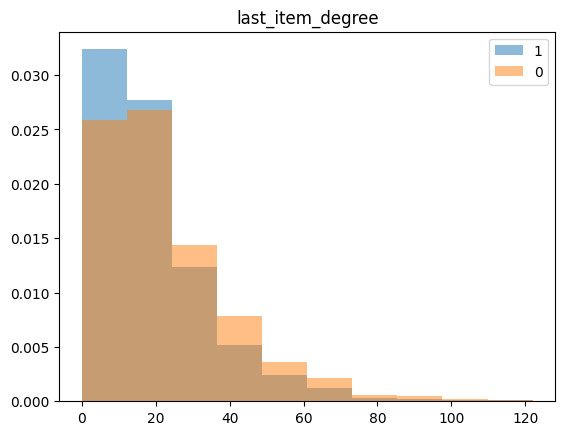

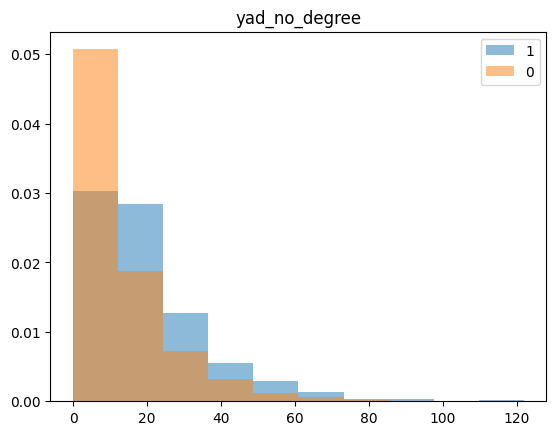

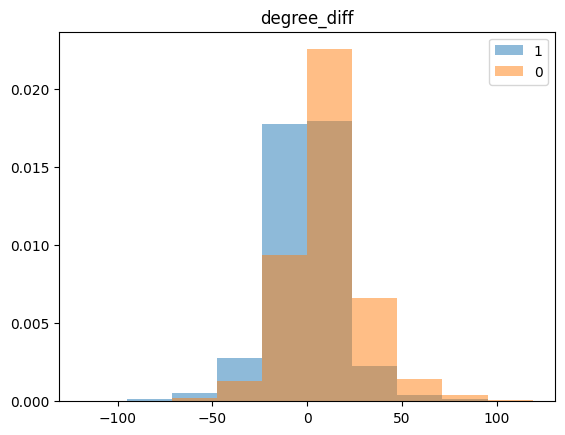

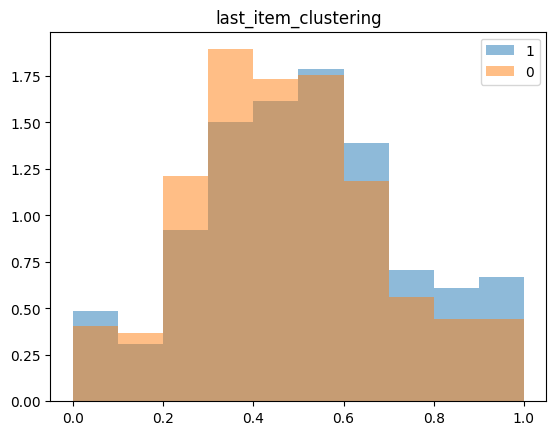

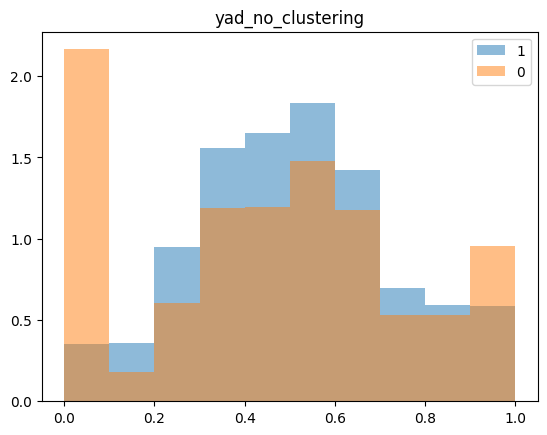

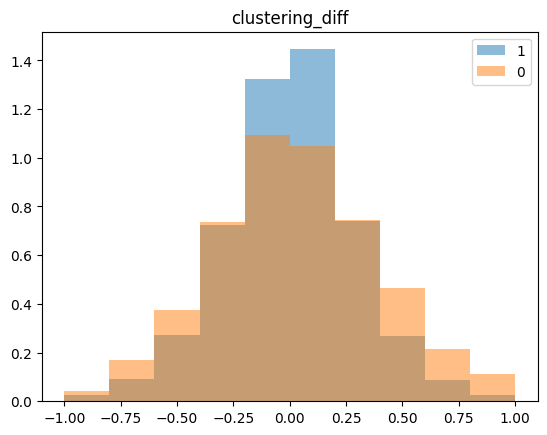

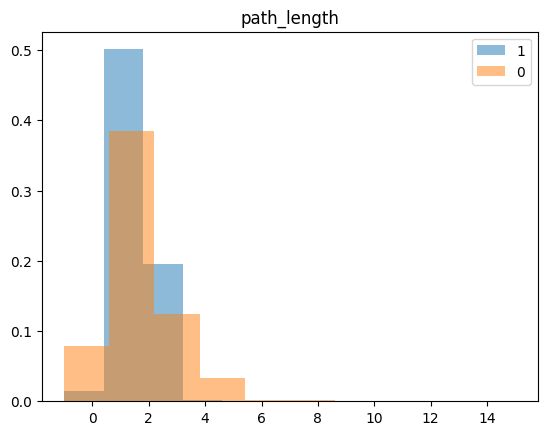

In [41]:
train_df, test_df, graph_feature_cols = add_graph_feature_train_test(train_df, test_df, train_test_log_df, yado_df)

In [42]:
"""
https://github.com/unonao/atmacup-15/blob/master/features/create.py
"""
def add_igraph_feature(g):
    pageranks = g.pagerank()
    print("PageRank:", len(pageranks))
    betweenness = g.betweenness()
    print("betweenness:", len(betweenness))
    eigenvector_centrality = g.eigenvector_centrality()
    print("eigenvector_centrality:", len(eigenvector_centrality))
    hub_score = g.hub_score()
    print("hub_score:", len(hub_score))
    authority_score = g.authority_score()
    print("authority_score:", len(authority_score))
    constraint = g.constraint()
    print("constraint:", len(constraint))
    # degree = g.degree()
    # print("degree:", len(degree))
    coreness = g.coreness()
    print("coreness:", len(coreness))
    eccentricity = g.eccentricity()
    print("eccentricity:", len(eccentricity))
    harmonic_centrality = g.harmonic_centrality()
    print("harmonic_centrality:", len(harmonic_centrality))

    node_df = pd.DataFrame(
        {
            "pageranks": pageranks,
            "betweenness": betweenness,
            "eigenvector_centrality": eigenvector_centrality,
            "hub_score": hub_score,
            "authority_score": authority_score,
            "constraint": constraint,
            "coreness": coreness,
            "eccentricity": eccentricity,
            "harmonic_centrality": harmonic_centrality,
        }
    )

    return node_df

In [43]:
"""
import igraph as ig

G = ig.Graph(directed=False)
G.add_vertices(len(yado_df))

edges = [(e1-1, e2-1) for e1, e2 in edges]
G.add_edges(edges)

node_df = add_igraph_feature(G)

igraph_feature_cols = node_df.columns.tolist() 

node_df['yad_no'] = node_df.index + 1

train_df = pd.merge(train_df, node_df, on='yad_no', how='left')
test_df = pd.merge(test_df, node_df, on='yad_no', how='left')

node_df.rename(columns={'yad_no': 'last_item'}, inplace=True)
rename_dict = dict([(col, f'{col}_last_item') for col in igraph_feature_cols])
node_df.rename(columns=rename_dict, inplace=True)

train_df = pd.merge(train_df, node_df, on='last_item', how='left')
test_df = pd.merge(test_df, node_df, on='last_item', how='left')

igraph_feature_cols += [f'{col}_last_item' for col in igraph_feature_cols]
"""

"\nimport igraph as ig\n\nG = ig.Graph(directed=False)\nG.add_vertices(len(yado_df))\n\nedges = [(e1-1, e2-1) for e1, e2 in edges]\nG.add_edges(edges)\n\nnode_df = add_igraph_feature(G)\n\nigraph_feature_cols = node_df.columns.tolist() \n\nnode_df['yad_no'] = node_df.index + 1\n\ntrain_df = pd.merge(train_df, node_df, on='yad_no', how='left')\ntest_df = pd.merge(test_df, node_df, on='yad_no', how='left')\n\nnode_df.rename(columns={'yad_no': 'last_item'}, inplace=True)\nrename_dict = dict([(col, f'{col}_last_item') for col in igraph_feature_cols])\nnode_df.rename(columns=rename_dict, inplace=True)\n\ntrain_df = pd.merge(train_df, node_df, on='last_item', how='left')\ntest_df = pd.merge(test_df, node_df, on='last_item', how='left')\n\nigraph_feature_cols += [f'{col}_last_item' for col in igraph_feature_cols]\n"

In [44]:
"""
for col in igraph_feature_cols:
    plt.hist(train_df[train_df[CFG.target_col]==1][col], alpha=0.5, label='1', density=True, bins=100)
    plt.hist(train_df[train_df[CFG.target_col]==0][col], alpha=0.5, label='0', density=True, bins=100)
    plt.title(col)
    plt.legend()
    plt.show()
"""

"\nfor col in igraph_feature_cols:\n    plt.hist(train_df[train_df[CFG.target_col]==1][col], alpha=0.5, label='1', density=True, bins=100)\n    plt.hist(train_df[train_df[CFG.target_col]==0][col], alpha=0.5, label='0', density=True, bins=100)\n    plt.title(col)\n    plt.legend()\n    plt.show()\n"

## embeddingとの類似度

In [45]:
from myutils.numba_func import calc_cos_sim_numba
def calc_cos_sim(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

In [46]:
def add_embedding_sim(train_df, test_df, user_path, item_path, embd_name, dimensions):
    output_col = f'cos_sim_{embd_name}'

    user_factors_df = pd.read_pickle(user_path)
    item_factors_df = pd.read_pickle(item_path)

    user_factor_cols = [f'user_factor_{i}' for i in range(dimensions)]
    item_factor_cols = [f'item_factor_{i}' for i in range(dimensions)]

    session2user_factor = dict(zip(user_factors_df['session_id'], user_factors_df[user_factor_cols].values))
    item2item_factor = dict(zip(item_factors_df['yad_no'], item_factors_df[item_factor_cols].values))


    results = []
    for session_id, yad_no in train_df[['session_id', 'yad_no']].values:
        user_factor = session2user_factor[session_id]
        item_factor = item2item_factor[yad_no]

        cos_sim = calc_cos_sim_numba(user_factor, item_factor)

        results.append(cos_sim)
    train_df[output_col] = results

    results = []
    for session_id, yad_no in test_df[['session_id', 'yad_no']].values:
        user_factor = session2user_factor[session_id]
        item_factor = item2item_factor[yad_no]

        cos_sim = calc_cos_sim_numba(user_factor, item_factor)

        results.append(cos_sim)
    test_df[output_col] = results

    # test_df[output_col] = [calc_cos_sim_numba(session2user_factor[session_id], item2item_factor[yad_no]) for session_id, yad_no in tqdm(test_df[['session_id', 'yad_no']].values)]

    """
    calc_list = [[session2user_factor[session_id], item2item_factor[yad_no]] for session_id, yad_no in tqdm(test_df[['session_id', 'yad_no']].values)]
    test_df[output_col] = calc_cos_sim_multiprocess(calc_list)
    """
    plt.hist(train_df[train_df[CFG.target_col]==1][output_col], alpha=0.5, label='1', density=True, bins=100)
    plt.hist(train_df[train_df[CFG.target_col]==0][output_col], alpha=0.5, label='0', density=True, bins=100)
    plt.title(output_col)
    plt.legend()
    plt.show()

    return train_df, test_df, output_col
    

In [47]:
embedding_cols = []

In [48]:
"""
for category in ['exterior', 'facility', 'food', 'others', 'room']:
    train_df, test_df, output_col = add_embedding_sim(train_df, test_df, f'../../datasets/image_embedding_pkl/image_embedding_{category}_user_factors_df.pkl', f'../../datasets/image_embedding_pkl/image_embedding_{category}_item_factors_df.pkl', f'image_embedding_{category}_all_item', 512)
    embedding_cols.append(output_col)
"""

"\nfor category in ['exterior', 'facility', 'food', 'others', 'room']:\n    train_df, test_df, output_col = add_embedding_sim(train_df, test_df, f'../../datasets/image_embedding_pkl/image_embedding_{category}_user_factors_df.pkl', f'../../datasets/image_embedding_pkl/image_embedding_{category}_item_factors_df.pkl', f'image_embedding_{category}_all_item', 512)\n    embedding_cols.append(output_col)\n"

In [49]:
"""
for category in ['exterior', 'facility', 'food', 'others', 'room']:
    train_df, test_df, output_col = add_embedding_sim(train_df, test_df, f'../../datasets/image_embedding_pkl/image_embedding_{category}_user_factors_last_item_df.pkl', f'../../datasets/image_embedding_pkl/image_embedding_{category}_item_factors_df.pkl', f'image_embedding_{category}_last_item', 512)
    embedding_cols.append(output_col)
"""

"\nfor category in ['exterior', 'facility', 'food', 'others', 'room']:\n    train_df, test_df, output_col = add_embedding_sim(train_df, test_df, f'../../datasets/image_embedding_pkl/image_embedding_{category}_user_factors_last_item_df.pkl', f'../../datasets/image_embedding_pkl/image_embedding_{category}_item_factors_df.pkl', f'image_embedding_{category}_last_item', 512)\n    embedding_cols.append(output_col)\n"

In [50]:
"""
%%time
vector_name = 'bpr'

user_suffix = ''
session_user_name = 'all'
dimensions = 64
train_df, test_df, output_col = add_embedding_sim(train_df, test_df, f'../../datasets/{vector_name}_pkl/{vector_name}_user_factors_{user_suffix}df.pkl', f'../../datasets/{vector_name}_pkl/{vector_name}_item_factors_df.pkl', f'{vector_name}_{session_user_name}_item', dimensions)
embedding_cols.append(output_col)


user_suffix = 'last_item_'
session_user_name = 'last'
dimensions = 64
train_df, test_df, output_col = add_embedding_sim(train_df, test_df, f'../../datasets/{vector_name}_pkl/{vector_name}_user_factors_{user_suffix}df.pkl', f'../../datasets/{vector_name}_pkl/{vector_name}_item_factors_df.pkl', f'{vector_name}_{session_user_name}_item', dimensions)
embedding_cols.append(output_col)
"""

"\n%%time\nvector_name = 'bpr'\n\nuser_suffix = ''\nsession_user_name = 'all'\ndimensions = 64\ntrain_df, test_df, output_col = add_embedding_sim(train_df, test_df, f'../../datasets/{vector_name}_pkl/{vector_name}_user_factors_{user_suffix}df.pkl', f'../../datasets/{vector_name}_pkl/{vector_name}_item_factors_df.pkl', f'{vector_name}_{session_user_name}_item', dimensions)\nembedding_cols.append(output_col)\n\n\nuser_suffix = 'last_item_'\nsession_user_name = 'last'\ndimensions = 64\ntrain_df, test_df, output_col = add_embedding_sim(train_df, test_df, f'../../datasets/{vector_name}_pkl/{vector_name}_user_factors_{user_suffix}df.pkl', f'../../datasets/{vector_name}_pkl/{vector_name}_item_factors_df.pkl', f'{vector_name}_{session_user_name}_item', dimensions)\nembedding_cols.append(output_col)\n"

In [51]:
"""
%%time
vector_name = 'lmf'

user_suffix = ''
session_user_name = 'all'
dimensions = 64
train_df, test_df, output_col = add_embedding_sim(train_df, test_df, f'../../datasets/{vector_name}_pkl/{vector_name}_user_factors_{user_suffix}df.pkl', f'../../datasets/{vector_name}_pkl/{vector_name}_item_factors_df.pkl', f'{vector_name}_{session_user_name}_item', dimensions)
embedding_cols.append(output_col)


user_suffix = 'last_item_'
session_user_name = 'last'
dimensions = 64
train_df, test_df, output_col = add_embedding_sim(train_df, test_df, f'../../datasets/{vector_name}_pkl/{vector_name}_user_factors_{user_suffix}df.pkl', f'../../datasets/{vector_name}_pkl/{vector_name}_item_factors_df.pkl', f'{vector_name}_{session_user_name}_item', dimensions)
embedding_cols.append(output_col)
"""

"\n%%time\nvector_name = 'lmf'\n\nuser_suffix = ''\nsession_user_name = 'all'\ndimensions = 64\ntrain_df, test_df, output_col = add_embedding_sim(train_df, test_df, f'../../datasets/{vector_name}_pkl/{vector_name}_user_factors_{user_suffix}df.pkl', f'../../datasets/{vector_name}_pkl/{vector_name}_item_factors_df.pkl', f'{vector_name}_{session_user_name}_item', dimensions)\nembedding_cols.append(output_col)\n\n\nuser_suffix = 'last_item_'\nsession_user_name = 'last'\ndimensions = 64\ntrain_df, test_df, output_col = add_embedding_sim(train_df, test_df, f'../../datasets/{vector_name}_pkl/{vector_name}_user_factors_{user_suffix}df.pkl', f'../../datasets/{vector_name}_pkl/{vector_name}_item_factors_df.pkl', f'{vector_name}_{session_user_name}_item', dimensions)\nembedding_cols.append(output_col)\n"

In [52]:
"""
%%time
vector_name = 'nmf'

user_suffix = ''
session_user_name = 'all'
train_df, test_df, output_col = add_embedding_sim(train_df, test_df, f'../../datasets/{vector_name}_pkl/{vector_name}_user_factors_{user_suffix}df.pkl', f'../../datasets/{vector_name}_pkl/{vector_name}_item_factors_df.pkl', f'{vector_name}_{session_user_name}_item', 256)
embedding_cols.append(output_col)


user_suffix = 'last_item_'
session_user_name = 'last'
train_df, test_df, output_col = add_embedding_sim(train_df, test_df, f'../../datasets/{vector_name}_pkl/{vector_name}_user_factors_{user_suffix}df.pkl', f'../../datasets/{vector_name}_pkl/{vector_name}_item_factors_df.pkl', f'{vector_name}_{session_user_name}_item', 256)
embedding_cols.append(output_col)
"""

"\n%%time\nvector_name = 'nmf'\n\nuser_suffix = ''\nsession_user_name = 'all'\ntrain_df, test_df, output_col = add_embedding_sim(train_df, test_df, f'../../datasets/{vector_name}_pkl/{vector_name}_user_factors_{user_suffix}df.pkl', f'../../datasets/{vector_name}_pkl/{vector_name}_item_factors_df.pkl', f'{vector_name}_{session_user_name}_item', 256)\nembedding_cols.append(output_col)\n\n\nuser_suffix = 'last_item_'\nsession_user_name = 'last'\ntrain_df, test_df, output_col = add_embedding_sim(train_df, test_df, f'../../datasets/{vector_name}_pkl/{vector_name}_user_factors_{user_suffix}df.pkl', f'../../datasets/{vector_name}_pkl/{vector_name}_item_factors_df.pkl', f'{vector_name}_{session_user_name}_item', 256)\nembedding_cols.append(output_col)\n"

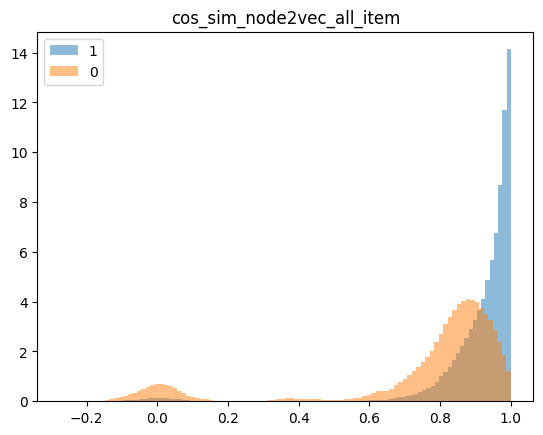

CPU times: user 2min 24s, sys: 2.64 s, total: 2min 26s
Wall time: 2min 26s


In [53]:
%%time
train_df, test_df, output_col = add_embedding_sim(train_df, test_df, '../../datasets/node2vec_pkl/node2vec_user_factors_df.pkl', '../../datasets/node2vec_pkl/node2vec_item_factors_df.pkl', 'node2vec_all_item', 256)
embedding_cols.append(output_col)

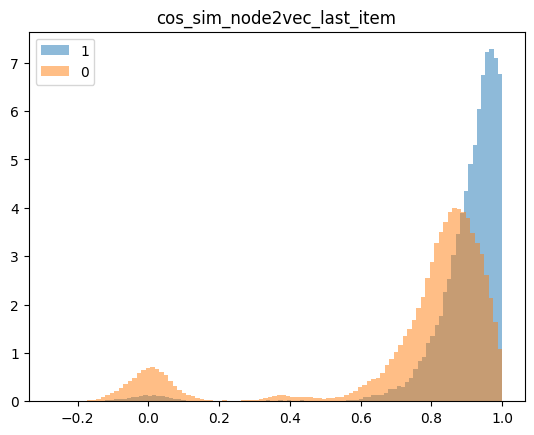

CPU times: user 2min 24s, sys: 2.67 s, total: 2min 26s
Wall time: 2min 26s


In [54]:
%%time
train_df, test_df, output_col = add_embedding_sim(train_df, test_df, '../../datasets/node2vec_pkl/node2vec_user_factors_last_item_df.pkl', '../../datasets/node2vec_pkl/node2vec_item_factors_df.pkl', 'node2vec_last_item', 256)
embedding_cols.append(output_col)

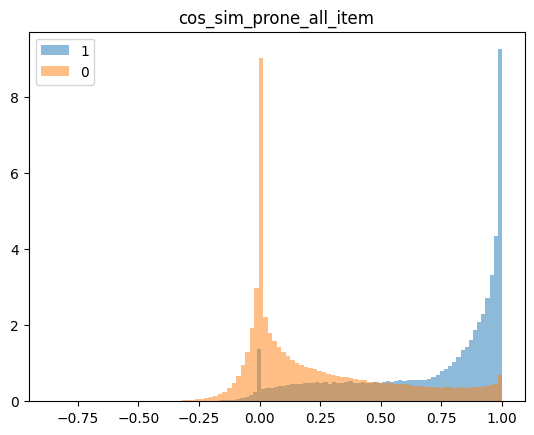

CPU times: user 5min 58s, sys: 4.39 s, total: 6min 2s
Wall time: 6min 2s


In [55]:
%%time
train_df, test_df, output_col = add_embedding_sim(train_df, test_df, '../../datasets/prone_pkl/prone_user_factors_df.pkl', '../../datasets/prone_pkl/prone_item_factors_df.pkl', 'prone_all_item', 1024)
embedding_cols.append(output_col)

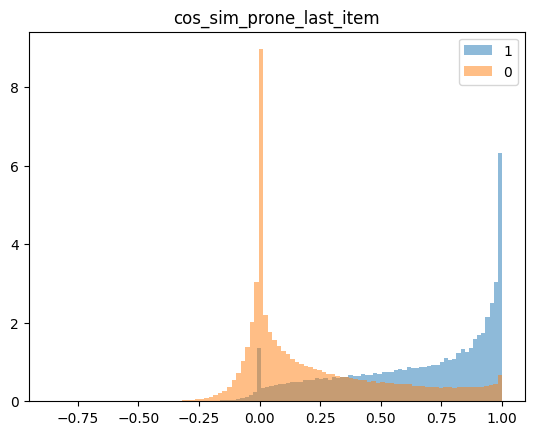

CPU times: user 5min 59s, sys: 4.87 s, total: 6min 3s
Wall time: 6min 4s


In [56]:
%%time
train_df, test_df, output_col = add_embedding_sim(train_df, test_df, '../../datasets/prone_pkl/prone_user_factors_last_item_df.pkl', '../../datasets/prone_pkl/prone_item_factors_df.pkl', 'prone_last_item', 1024)
embedding_cols.append(output_col)

In [57]:
# train_df, test_df, output_col = add_embedding_sim(train_df, test_df, '../../datasets/word2vec_nn_pkl/word2vec_nn_user_factors_last_item_df.pkl', '../../datasets/word2vec_nn_pkl/word2vec_nn_item_factors_df.pkl', 'word2vec_nn_last_item', 256)
# embedding_cols.append(output_col)

In [58]:
# train_df, test_df, output_col = add_embedding_sim(train_df, test_df, '../../datasets/word2vec_nn_pkl/word2vec_nn_user_factors_df.pkl', '../../datasets/word2vec_nn_pkl/word2vec_nn_item_factors_df.pkl', 'word2vec_nn_all_item', 256)
# embedding_cols.append(output_col)

## user feature

In [59]:
def add_user_cols(train_df, test_df, train_test_log_df):
    user_cols = ['session_item_count', 'session_item_nunique']

    session_item_count_df = train_test_log_df.groupby('session_id').size().reset_index()
    session_item_count_df.rename(columns={0: 'session_item_count'}, inplace=True)
    train_df = pd.merge(train_df, session_item_count_df, on='session_id', how='left')
    test_df = pd.merge(test_df, session_item_count_df, on='session_id', how='left')

    session_item_nunique_df = train_test_log_df.groupby('session_id')['yad_no'].nunique().reset_index()
    session_item_nunique_df.rename(columns={'yad_no': 'session_item_nunique'}, inplace=True)
                                  
    train_df = pd.merge(train_df, session_item_nunique_df, on='session_id', how='left')
    test_df = pd.merge(test_df, session_item_nunique_df, on='session_id', how='left')

    return train_df, test_df, user_cols

In [60]:
train_df, test_df, user_cols = add_user_cols(train_df, test_df, train_test_log_df)

## yadの出現回数、sessionのunique数

In [61]:
def add_yad_occur_count(target_df: pd.DataFrame, target_log_df: pd.DataFrame) -> pd.DataFrame:
    
    yad_occur_count_df = target_log_df.groupby('yad_no').size().reset_index()
    yad_occur_count_df.rename(columns={0: 'yad_occur_count'}, inplace=True)
    target_df = pd.merge(target_df, yad_occur_count_df, on='yad_no', how='left')

    yad_session_nunique_df = target_log_df.groupby('yad_no')['session_id'].nunique().reset_index()
    yad_session_nunique_df.rename(columns={'session_id': 'yad_session_nunique'}, inplace=True)
    target_df = pd.merge(target_df, yad_session_nunique_df, on='yad_no', how='left')
    
    return target_df

In [62]:
train_df = add_yad_occur_count(train_df, train_test_log_df)
test_df = add_yad_occur_count(test_df, train_test_log_df)

## area内での、出現回数のrank

In [63]:
def add_rank_same_area(train_df: pd.DataFrame, test_df: pd.DataFrame, train_test_log_df: pd.DataFrame, yado_df: pd.DataFrame, area_col:str):
    counter = Counter(train_test_log_df['yad_no'].values)
    sml_cd_to_yad_dict = yado_df.groupby(area_col)['yad_no'].apply(lambda x: x.tolist()).to_dict()

    # counterの値で、yad_noをソート
    for sml_cd in sml_cd_to_yad_dict.keys():
        sml_cd_to_yad_dict[sml_cd] = sorted(sml_cd_to_yad_dict[sml_cd], key=lambda x: counter[x], reverse=True)

    results = []
    columns = [f'yad_occur_rank_{area_col}']
    for sml_cd in sml_cd_to_yad_dict.keys():
        yad_no_list = sml_cd_to_yad_dict[sml_cd]
        for rank, yad_no in enumerate(yad_no_list):
            # results.append([sml_cd, yad_no, counter[yad_no], rank+1])
            results.append([yad_no, rank+1])
            
    sml_cd_count_df = pd.DataFrame(results, columns=['yad_no'] + columns)

    train_df = pd.merge(train_df, sml_cd_count_df, on=['yad_no'], how='left')
    test_df = pd.merge(test_df, sml_cd_count_df, on=['yad_no'], how='left')

    return train_df, test_df, columns

In [64]:
yad_count_cols = []

for area_col in ['sml_cd', 'wid_cd', 'ken_cd', 'lrg_cd']:
    train_df, test_df, cols = add_rank_same_area(train_df, test_df, train_test_log_df, yado_df, area_col)
    yad_count_cols += cols

## last_itemの出現回数、area内での出現回数,rank

In [65]:
def add_yad_occur_count_last_item(target_df: pd.DataFrame, target_log_df: pd.DataFrame) -> pd.DataFrame:
    target_log_df = target_log_df.rename(columns={'yad_no': 'last_item'})

    yad_occur_count_df = target_log_df.groupby('last_item').size().reset_index()
    yad_occur_count_df.rename(columns={0: 'yad_occur_count_last_item'}, inplace=True)
    target_df = pd.merge(target_df, yad_occur_count_df, on='last_item', how='left')

    yad_session_nunique_df = target_log_df.groupby('last_item')['session_id'].nunique().reset_index()
    yad_session_nunique_df.rename(columns={'session_id': 'yad_session_nunique_last_item'}, inplace=True)
    target_df = pd.merge(target_df, yad_session_nunique_df, on='last_item', how='left')
    
    return target_df

In [66]:

def add_rank_same_area_last_item(train_df: pd.DataFrame, test_df: pd.DataFrame, train_test_log_df: pd.DataFrame, yado_df: pd.DataFrame, area_col:str):
    counter = Counter(train_test_log_df['yad_no'].values)
    sml_cd_to_yad_dict = yado_df.groupby(area_col)['yad_no'].apply(lambda x: x.tolist()).to_dict()

    # counterの値で、yad_noをソート
    for sml_cd in sml_cd_to_yad_dict.keys():
        sml_cd_to_yad_dict[sml_cd] = sorted(sml_cd_to_yad_dict[sml_cd], key=lambda x: counter[x], reverse=True)

    results = []
    columns = [f'yad_occur_rank_last_item_{area_col}']
    for sml_cd in sml_cd_to_yad_dict.keys():
        yad_no_list = sml_cd_to_yad_dict[sml_cd]
        for rank, yad_no in enumerate(yad_no_list):
            # results.append([sml_cd, yad_no, counter[yad_no], rank+1])
            results.append([yad_no, rank+1])
            
    sml_cd_count_df = pd.DataFrame(results, columns=['last_item'] + columns)

    train_df = pd.merge(train_df, sml_cd_count_df, on=['last_item'], how='left')
    test_df = pd.merge(test_df, sml_cd_count_df, on=['last_item'], how='left')

    return train_df, test_df, columns

In [67]:
yad_count_last_item_cols = ['yad_occur_count_last_item', 'yad_session_nunique_last_item']

train_df = add_yad_occur_count_last_item(train_df, train_test_log_df)
test_df = add_yad_occur_count_last_item(test_df, train_test_log_df)

for area_col in ['sml_cd', 'wid_cd', 'ken_cd', 'lrg_cd']:
    train_df, test_df, cols = add_rank_same_area_last_item(train_df, test_df, train_test_log_df, yado_df, area_col)
    yad_count_last_item_cols += cols

### 最後のitemと同じ地域か

## yad_noの出現回数をareaで集約 

In [68]:
"""
train_test_log_df_yado = train_log_df.merge(yado_df, on='yad_no', how='left')

yad_area_count_agg_cols = []
for col in area_cols:
    count_df = train_test_log_df_yado.groupby([col, 'yad_no']).size().reset_index()
    count_df.rename(columns={0: f'yad_no_count_{col}'}, inplace=True)

    grp_df = count_df.groupby(col)[[f'yad_no_count_{col}']].agg(['mean', 'max', 'min', 'std', 'median', 'sum'])
    grp_df.columns = ['_'.join(c) + f'@{area_col}' for c in grp_df.columns]

    train_df = pd.merge(train_df, grp_df, on=col, how='left')
    test_df = pd.merge(test_df, grp_df, on=col, how='left')

    yad_area_count_agg_cols += grp_df.columns.tolist()
"""

"\ntrain_test_log_df_yado = train_log_df.merge(yado_df, on='yad_no', how='left')\n\nyad_area_count_agg_cols = []\nfor col in area_cols:\n    count_df = train_test_log_df_yado.groupby([col, 'yad_no']).size().reset_index()\n    count_df.rename(columns={0: f'yad_no_count_{col}'}, inplace=True)\n\n    grp_df = count_df.groupby(col)[[f'yad_no_count_{col}']].agg(['mean', 'max', 'min', 'std', 'median', 'sum'])\n    grp_df.columns = ['_'.join(c) + f'@{area_col}' for c in grp_df.columns]\n\n    train_df = pd.merge(train_df, grp_df, on=col, how='left')\n    test_df = pd.merge(test_df, grp_df, on=col, how='left')\n\n    yad_area_count_agg_cols += grp_df.columns.tolist()\n"

## 特徴量生成

In [69]:
gc.collect()

111516

In [70]:
num_cols = yad_cols
# num_cols += [col for col in train_df.columns if 'rank' in col]
# num_cols += [col for col in train_df.columns if 'count' in col]

num_cols += candidate_rank_cols
num_cols += ['yad_occur_count', 'yad_session_nunique']
num_cols += yad_count_cols
num_cols += user_cols
num_cols += last_item_coo_count_cols

num_cols += embedding_cols

num_cols += yad_last_cols

num_cols += graph_feature_cols
# num_cols += igraph_feature_cols

num_cols += yad_count_last_item_cols

# 1stageでは抜く
# num_cols += all_item_coo_count_cols

# num_cols += last_item_set_similarity_cols

num_cols += ['candidate_name_num']

In [71]:
CFG.outputs_path

'../../outputs/atmacup_16/train_gbdt_1stage_feature_only_exp001/'

## 保存

In [72]:
import pickle

os.makedirs(CFG.outputs_path + 'feature_pkl/', exist_ok=True)

train_df.to_pickle(CFG.outputs_path + 'feature_pkl/train_df.pkl')
test_df.to_pickle(CFG.outputs_path + 'feature_pkl/test_df.pkl')

# num_colsをpickleで保存
pickle.dump(num_cols, open(CFG.outputs_path + 'feature_pkl/num_cols.pkl', 'wb'))